## RNAPII anchored intagrative chromatin state analysis using sci-mtChIL-seq datasets

In [1]:
Sys.setenv(LANGUAGE = "en")
options(warn = -1)

library(GenomicRanges)
library(GenomicFeatures)
library(Seurat)
library(tidyverse)
source('R/mytools.R')

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, saveRDS, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: AnnotationDbi



In [2]:
mgene_coding_uni <- readRDS('data/out/mgene_coding_uni.rds')

mgene_coding_use <- mgene_coding_uni[!str_detect(mgene_coding_uni$symbol, "Rik$")]
mgene_coding_use <- mgene_coding_use[!str_detect(mgene_coding_use$symbol, "Rik2$")]
mgene_coding_use <- mgene_coding_use[!str_detect(mgene_coding_use$symbol, "^Gm")]
tmp <- mgene_coding_use %>% gr2reg() %>% reg2gr()
nol <- findOverlaps(tmp,tmp) %>% 
  as_tibble() %>% 
  mutate(queryHits = mgene_coding_use$symbol[queryHits]) %>%
  count(queryHits) %>% filter(n>1) %>% arrange(-n)
nol2 <- nol %>% 
  filter(n == 2) %>%
  pull(queryHits) %>%
  map(~findOverlaps(tmp,tmp[mgene_coding_use$symbol==.x]) %>%
        queryHits() %>% mgene_coding_use[.] %>%
        as_tibble() %>% arrange(-width) %>%
        pull(symbol) %>% head(1)) %>%
  unlist() %>% unique()
nol3 <- nol %>%
  filter(n>2) %>% pull(queryHits)
nol23 <- unique(c(nol2,nol3))
mgene_coding_use <- mgene_coding_use[!mgene_coding_use$symbol %in% nol23]

In [3]:
## Create Seurat object 
#
# sm <- sprintf(
#   "data/matrix/part2/RNAPII_RNAPII-%s_r1_genebody.rds",
#   c("H3K4me3","Brg1","H3K27me3","H3K27ac")
#   ) %>%
#   map(readRDS) %>% ldecoyMerge()
# colnames(sm) <- paste0('r1_',colnames(sm))
# meta <- tibble(cell = colnames(sm)) %>%
#   separate(cell,into = c('rep','sample','Pair','ab','lib_id','t5'),remove = F) %>%
#   mutate(
#     sample = factor(sample,levels = c("MyoDminus","D0","D24","D72"))) %>%
#   tib2df()
# 
# nih3t3 <- CreateSeuratObject(sm,meta.data = meta,min.features = 150,min.cells = 50)
# nih3t3[["RNA"]] <- split(nih3t3[["RNA"]], f = nih3t3$Pair)
# nih3t3 <- NormalizeData(nih3t3,scale.factor = 3000, verbose = FALSE)
# nih3t3 <- FindVariableFeatures(nih3t3, verbose = FALSE)
# vfs <- HVFInfo(nih3t3) %>%
#   as_tibble(rownames = 'symbol') %>%
#   filter(symbol %in% mgene_coding_use$symbol) %>%
#   arrange(-variance.standardized) %>%
#   pull(symbol) %>% head(10000)
# nih3t3 <- ScaleData(nih3t3,features = vfs, verbose = FALSE)
# nih3t3 <- RunPCA(nih3t3,features = vfs, verbose = FALSE)
# nih3t3 <- IntegrateLayers(
#   object = nih3t3,method = HarmonyIntegration, 
#   orig.reduction = "pca",new.reduction = 'harmony',verbose = TRUE
#   )
# nih3t3 <- RunUMAP(nih3t3,dims = 2:16,reduction = 'harmony',verbose = FALSE)
# nih3t3 <- FindNeighbors(nih3t3,dims = 2:16,reduction = 'harmony',k.param = 30)
# nih3t3 <- FindClusters(nih3t3,algorithm = 4,method = 'igraph',resolution = .6)

In [4]:
nih3t3 <- readRDS('data/seuratObject_nih3t3_RNAPII_chromMarks.rds')
vfs <- HVFInfo(nih3t3) %>%
  as_tibble(rownames = 'symbol') %>%
  filter(symbol %in% mgene_coding_use$symbol) %>%
  arrange(-variance.standardized) %>%
  pull(symbol) %>% head(10000)

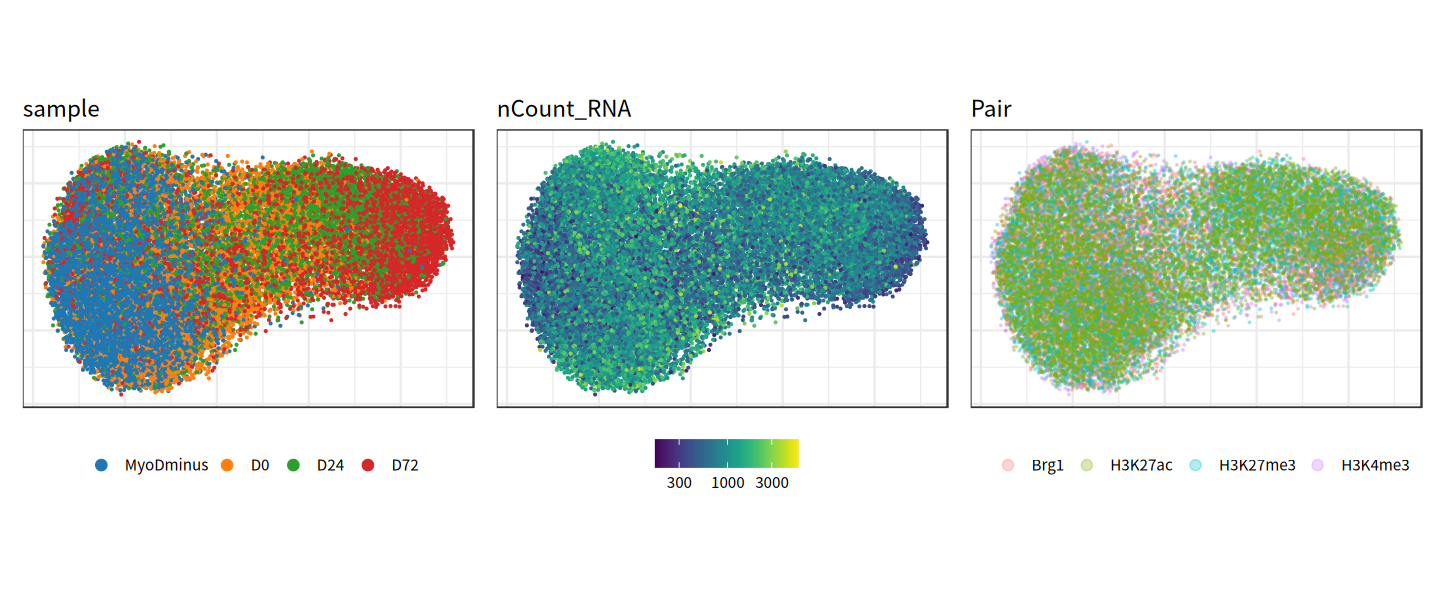

In [5]:
options(repr.plot.width = 12, repr.plot.height = 5) 
patchwork::wrap_plots(
  list(
    dimplot(nih3t3,'sample'),
    dimplot(nih3t3,'nCount_RNA',scale_color_log10 = T),
    dimplot(nih3t3,'Pair',palette = F,alpha = .3)
    )
  ) & theme(legend.position = 'bottom')

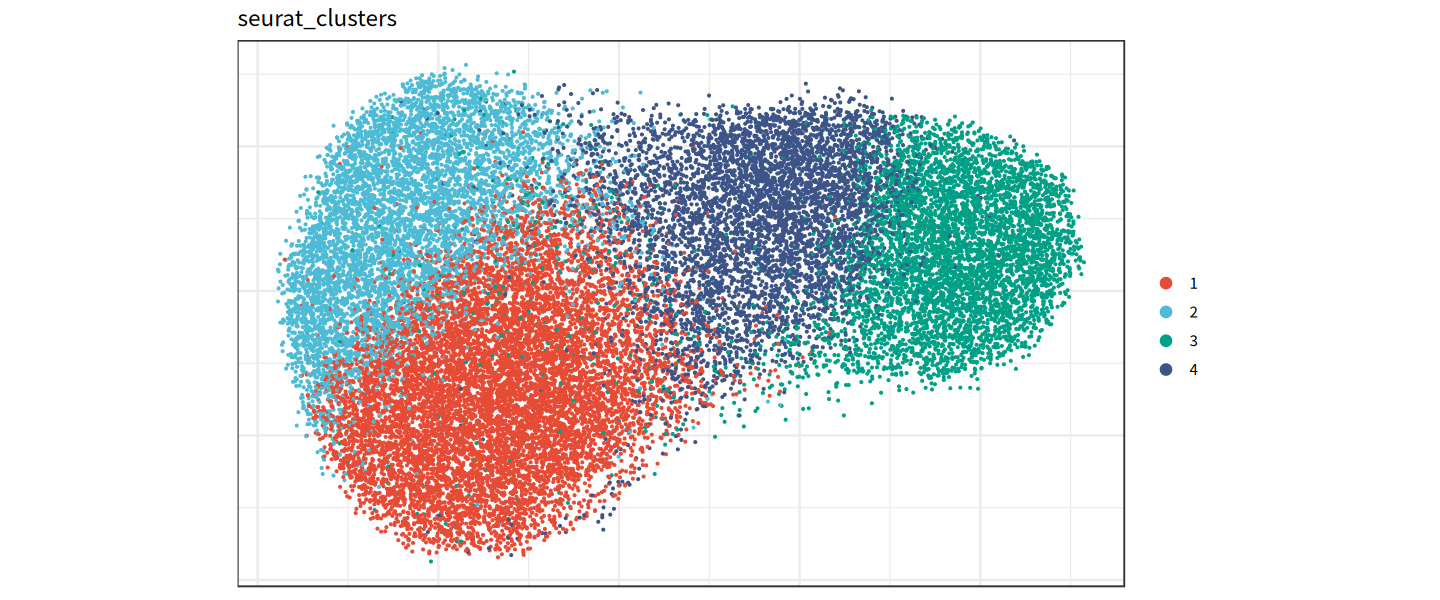

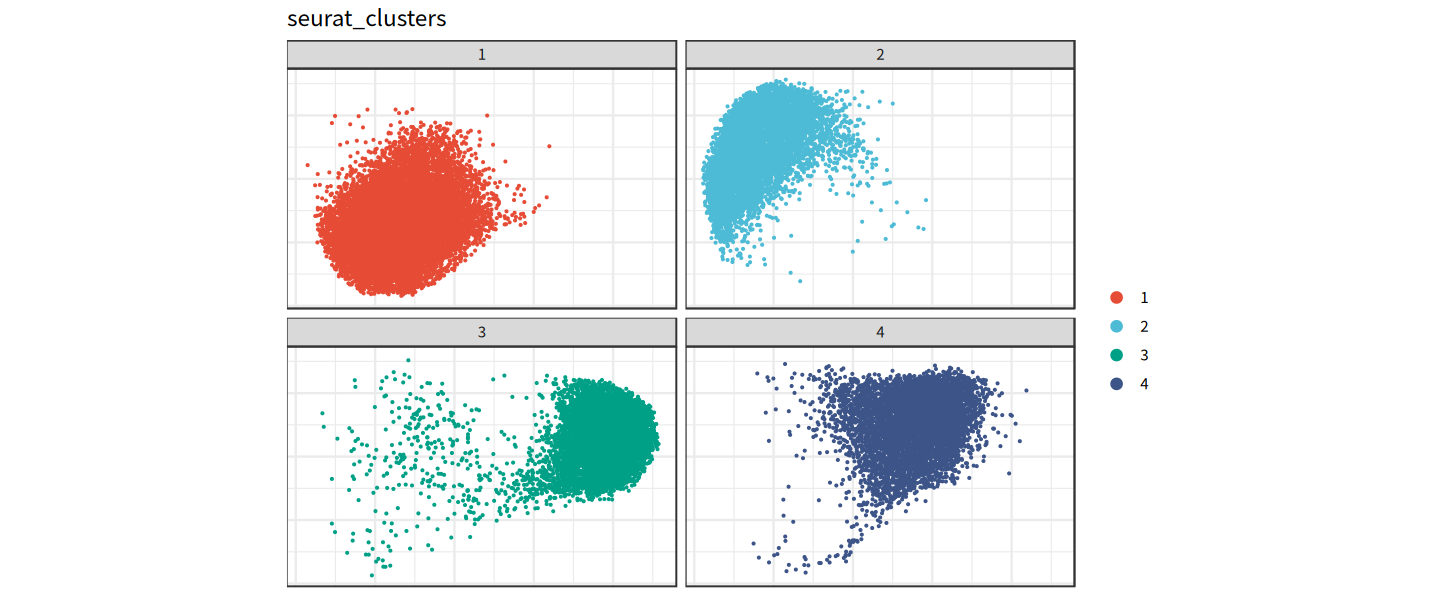

In [6]:
dimplot(nih3t3,'seurat_clusters',palette = F) +
  ggsci::scale_color_npg()
dimplot(nih3t3,'seurat_clusters',palette = F) + 
  facet_wrap(~seurat_clusters) + ggsci::scale_color_npg()

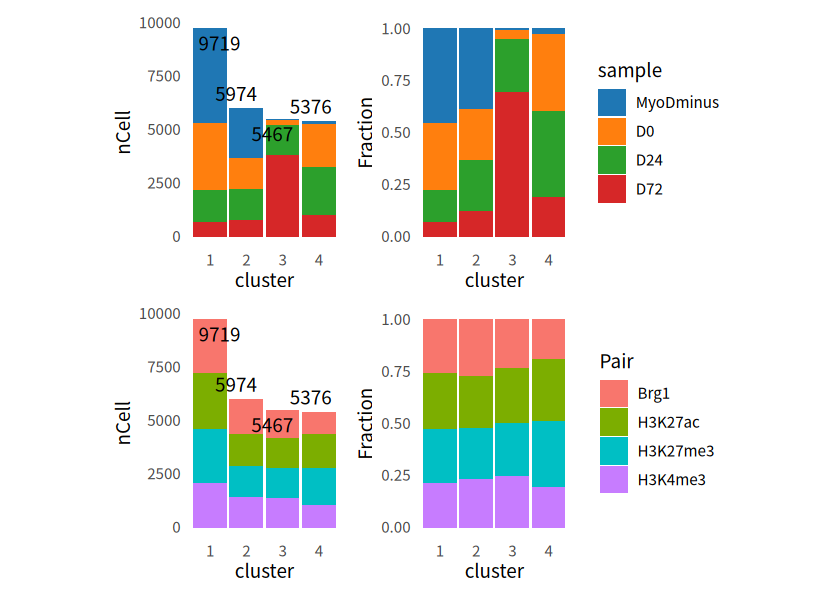

In [7]:
options(repr.plot.width = 7, repr.plot.height = 5) 
{
  nih3t3 %>%
    seu2tab() %>%
    freqfrac('seurat_clusters','sample')
}/{
  nih3t3 %>%
    seu2tab() %>%
    freqfrac('seurat_clusters','Pair',pal = F)
} & theme(aspect.ratio = 1.5) & labs(x = 'cluster') 

In [8]:
cluster_mks <- FindAllMarkers(JoinLayers(nih3t3),only.pos = TRUE) %>% as_tibble() 
cluster_mks %>% filter(p_val_adj < 0.05) %>% count(cluster)

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4



cluster,n
<fct>,<int>
1,1424
2,263
3,536
4,590


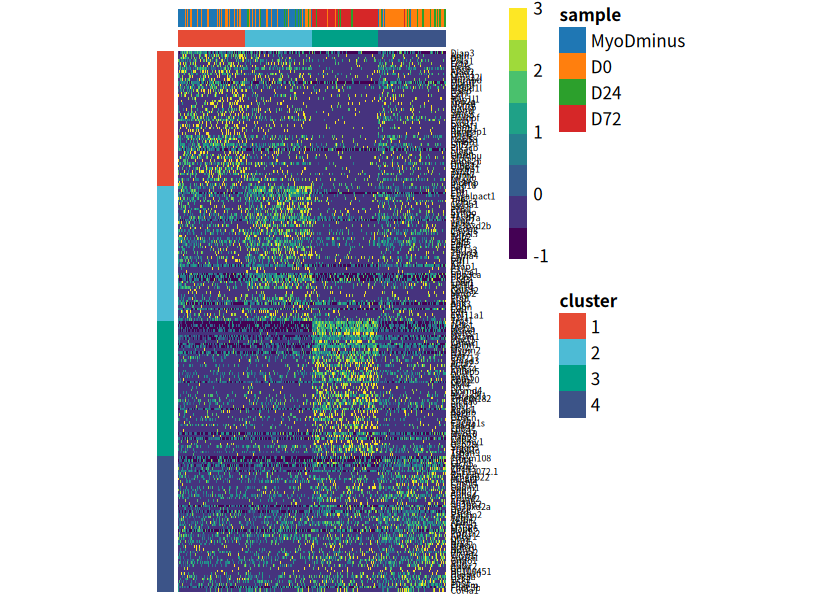

In [9]:
useg <- cluster_mks %>%
  arrange(p_val_adj) %>%
  filter(gene %in% vfs,!duplicated(gene)) %>%
  with(split(gene,cluster)) %>% map(head,n = 50) 
mat <- GetAssayData(JoinLayers(nih3t3),layer = 'data')[unlist(useg),] 
smat <- GetAssayData(JoinLayers(nih3t3),layer = 'scale.data')[unlist(useg),] 
mats <- nih3t3 %>% seu2tab() %>% with(split(cell,seurat_clusters)) %>%
  map2(useg,~{ 
    usec <- colSums(mat[.y,.x]>0) %>% sort(decreasing = TRUE) %>% head(200) %>% names()
    return(smat[,usec])
    })
mat <- do.call(cbind,mats)
mat[mat > 3] <- 3
ord <- nih3t3 %>% 
  seu2tab() %>% filter(cell %in% colnames(mat)) %>% 
  arrange(seurat_clusters,-nCount_RNA) %>% pull(cell)
anno_his <- nih3t3 %>% seu2tab() %>% select(cell,seurat_clusters,sample) %>% 
  rename(cluster = seurat_clusters) %>% tib2df() %>% .[colnames(mat),]
anno_his2 <- tibble(
  gene = unlist(useg),
  cluster = as.character(rep(1:4,each = 50))
  ) %>% 
  tib2df()
pal_his <- list(
  sample = structure(dcolor$palette(4),names = c("MyoDminus","D0","D24","D72")),
  cluster = structure(ggsci::scale_color_npg()$palette(4),names = as.character(1:4))
  )
pheatmap::pheatmap(
  mat[,ord],
  cluster_rows = F,
  cluster_cols = F,
  show_rownames = T,
  show_colnames = F,
  treeheight_row = F,
  color = viridis::viridis(8),
  annotation_col = anno_his,
  annotation_row = anno_his2,
  annotation_colors = pal_his,
  cellwidth = .2,
  fontsize_row = 5,
  annotation_names_row = F,
  annotation_names_col = F
  )

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


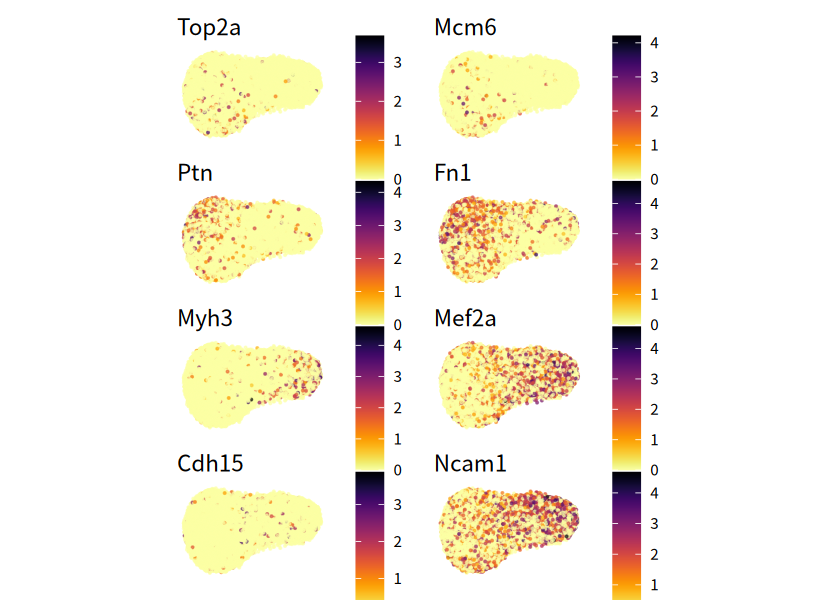

In [10]:
c("Top2a","Mcm6",
  "Ptn","Fn1",
  "Myh3","Mef2a",
  "Cdh15","Ncam1") %>%
  dimplot(nih3t3,.,patchwork_ncol = 2,empha = T,Theme = theme_minimal,alpha = .6) & 
    theme(panel.grid = element_blank()) & 
    viridis::scale_color_viridis(option = "inferno", discrete = FALSE, direction = -1)

In [11]:
ont <- cluster_mks %>%
  filter(cluster %in% 1:4) %>%
  with(split(gene,cluster)) %>%
  map(head,300) %>%
  compclus(simplify = TRUE)

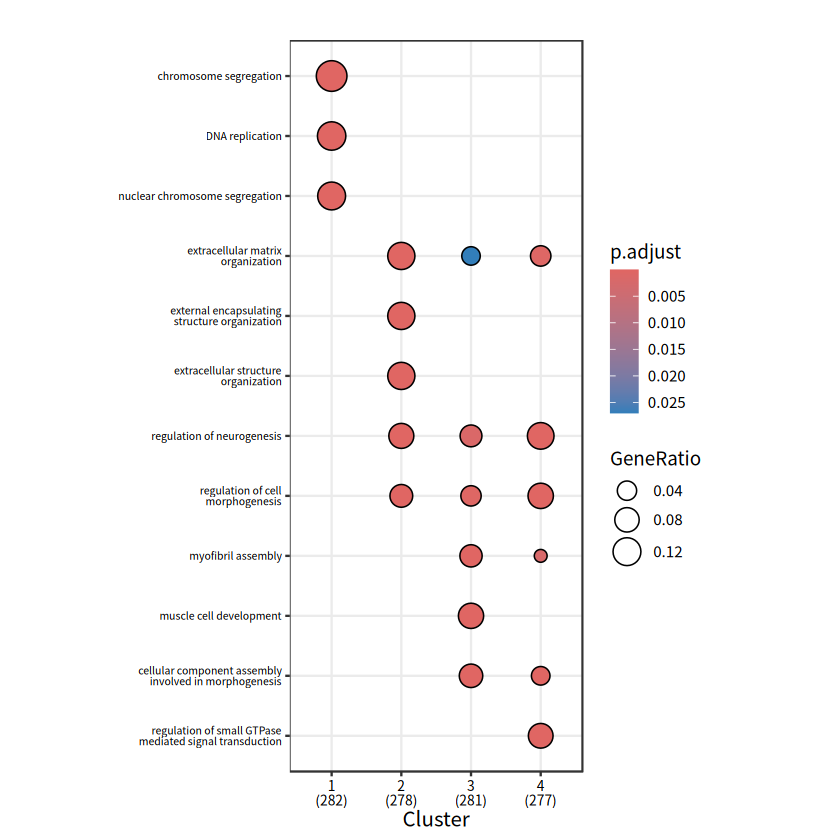

In [12]:
options(repr.plot.width = 7, repr.plot.height = 7) 
clusterProfiler::dotplot(ont,showCategory = 3) + 
  theme(aspect.ratio = 2.5,axis.text.y = element_text(size = 6),axis.text.x = element_text(size = 8))

In [13]:
keys <- c("H3K4me3","Brg1","H3K27me3","H3K27ac")
gsms <- c(
  'H3K4me3_RNAPII-H3K4me3_r1_TSSud2p5k.rds',
  'Brg1_RNAPII-Brg1_r1_genebody.rds',
  'H3K27me3_RNAPII-H3K27me3_r1_genebody.rds',
  'H3K27ac_RNAPII-H3K27ac_r1_genebody.rds'
  ) %>%
  structure(names = keys) %>%
  map(~readRDS(
    sprintf("data/matrix/part2/%s",.x)
    ) %>%
    relabel_cols('r1'))
gsms %>%
  map(dim)

$H3K4me3
[1] 21837  6049

$Brg1
[1] 19403  6822

$H3K27me3
[1] 19387  7399

$H3K27ac
[1] 19392  7486

In [14]:
cluster <- nih3t3$seurat_clusters 
mod <- model.matrix(~cluster-1)
rownames(mod) <- colnames(nih3t3)

gsms_scaled <- list()
for(i in names(gsms)){
  sm <- gsms[[i]]
  sm <- (10^4)*t(t(sm)/colSums(sm))
  sm <- log(sm+1)
  sm <- t(scale(t(sm)))
  gsms_scaled[[i]] <- sm
}

gsm_avg <- list()
for(i in names(gsms_scaled)){
  cell <- intersect(colnames(gsms_scaled[[i]]),rownames(mod))
  mat <- gsms_scaled[[i]][,cell]
  mod_ <- mod[cell,]
  mod_ <- t(t(mod_)/colSums(mod_))
  mat <- mat %*% mod_
  gs <- intersect(rownames(mat),mgene_coding_use$symbol)
  mat <- mat[gs,]
  mat <- relabel_cols(mat,i)
  mat <- as_tibble(mat,rownames = "symbol")
  gsm_avg[[i]] <- mat
}

head(gsm_avg[[1]])

symbol,H3K4me3_cluster1,H3K4me3_cluster2,H3K4me3_cluster3,H3K4me3_cluster4
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
AI837181,-0.008947169,-0.055119685,-0.000185434,0.078014965
AI846148,-0.002786063,-0.044381987,0.091736030,-0.009307292
Aamdc,-0.005938794,-0.026621933,0.060117228,0.016928156
Aars,0.048852381,-0.014376851,-0.067414776,0.044520813
Abcc1,0.043165058,0.015737441,-0.052446218,0.028039605
Abhd16a,-0.002288549,0.006523512,0.004647891,0.026425099


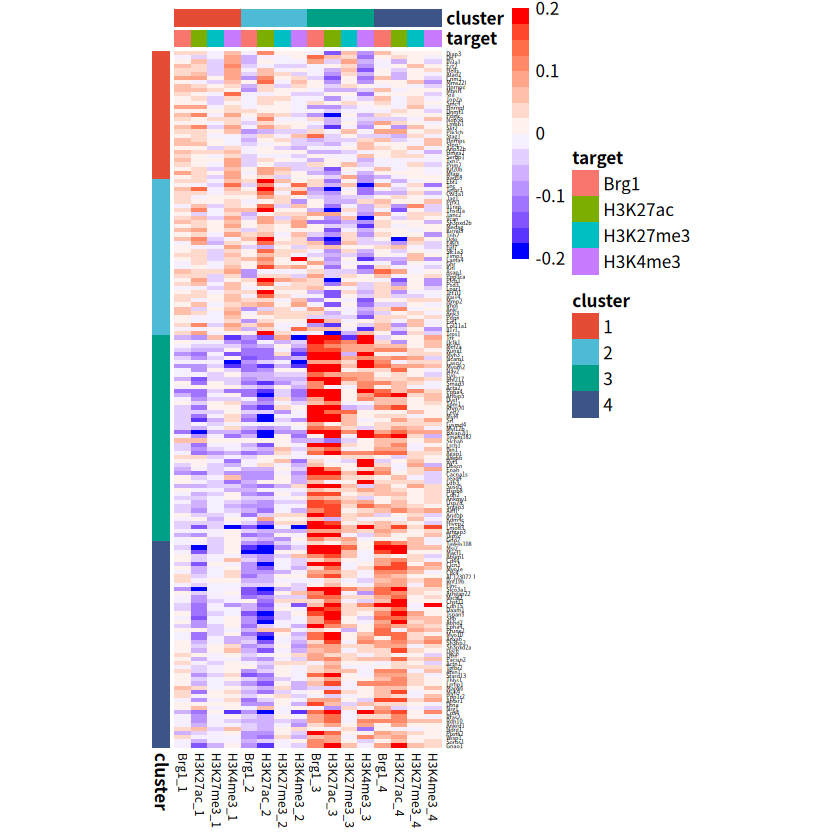

In [15]:
gsm_avgm <- gsm_avg %>% 
  linner_join(by = 'symbol') %>%
  tib2df() %>%
  .[rowSums(.)>0,] 
useg <- cluster_mks %>% 
  mutate(rank = row_number(),.by = cluster) %>%
  arrange(rank,p_val_adj) %>%
  filter(
    gene %in% vfs,
    !duplicated(gene)
    ) %>%
  with(split(gene,cluster)) %>% 
  map(head,n = 50) %>%
  map(~intersect(.x,rownames(gsm_avgm)))
useg_ <- useg %>% map(~intersect(.x,rownames(gsm_avgm)))
tmp <- as.matrix(gsm_avgm[unlist(useg_),])
ma <- 0.2; mi <- -0.2
colnames(tmp) <- sub("cluster","",colnames(tmp))

tmp[tmp > ma] <- ma
tmp[tmp < mi] <- mi

pal <- list(
  target = structure(c(ggColorHue(4)),names = c("Brg1","H3K27ac","H3K27me3","H3K4me3")),
  cluster = structure(ggsci::scale_color_npg()$palette(4),names = as.character(1:4))
  )
anno <- tibble(lab = colnames(tmp)) %>%
  separate(lab,into = c("target","cluster"),remove = F) %>%
  tib2df()
anno2 <- tibble(
  gene = unlist(useg_),
  cluster = rep(as.character(1:4),map_int(useg_,length))
  ) %>%
  tib2df()
bwr <- scale_color_gradient2(low = 'blue',mid = 'white',high = 'red')
ord <- anno %>% arrange(cluster,target) %>% rownames()
pheatmap::pheatmap(
  tmp[,ord],cellwidth = 10,angle_col = 270,fontsize_row = 3,fontsize_col = 7,
  treeheight_col = 10,border_color = NA,annotation_colors = pal,
  annotation_col = anno,annotation_row = anno2,cluster_rows = F,cluster_cols = F,
  color = bwr$palette(seq(0,1,len = 16)))


In [16]:
nih3t3_j <- JoinLayers(nih3t3)
sfs <- c(H3K4me3 = 2500,Brg1 = 1000,H3K27me3 = 1000,H3K27ac = 1000)
for(i in names(gsms)){
  cells <- intersect(colnames(nih3t3_j),colnames(gsms[[i]]))
  genes <- rownames(gsms[[i]])
  tmp <- CreateAssayObject(gsms[[i]][genes,cells])
  tmp <- NormalizeData(tmp,scale.factor = sfs[i])
  nih3t3_j[[i]] <- tmp
}

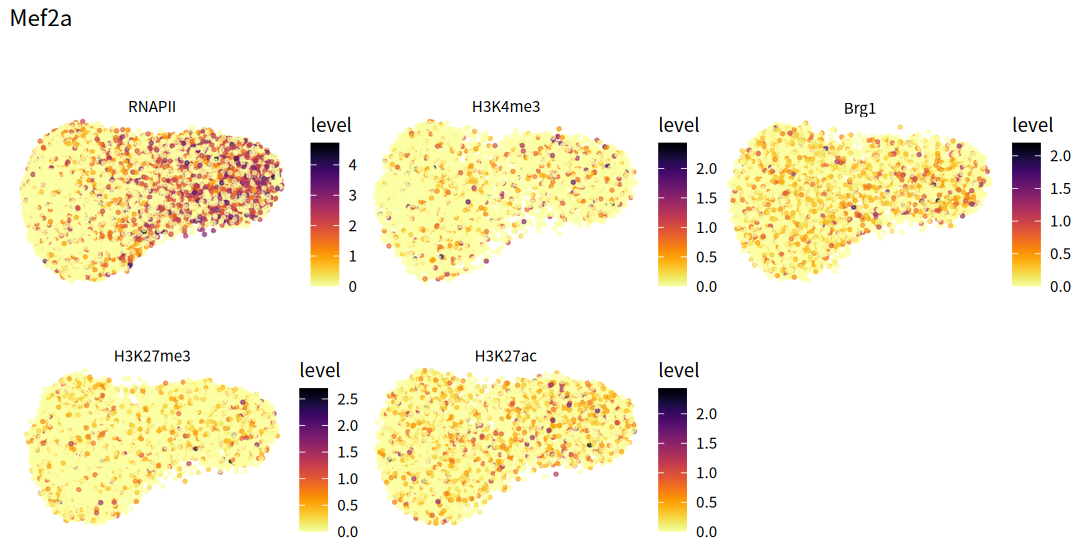

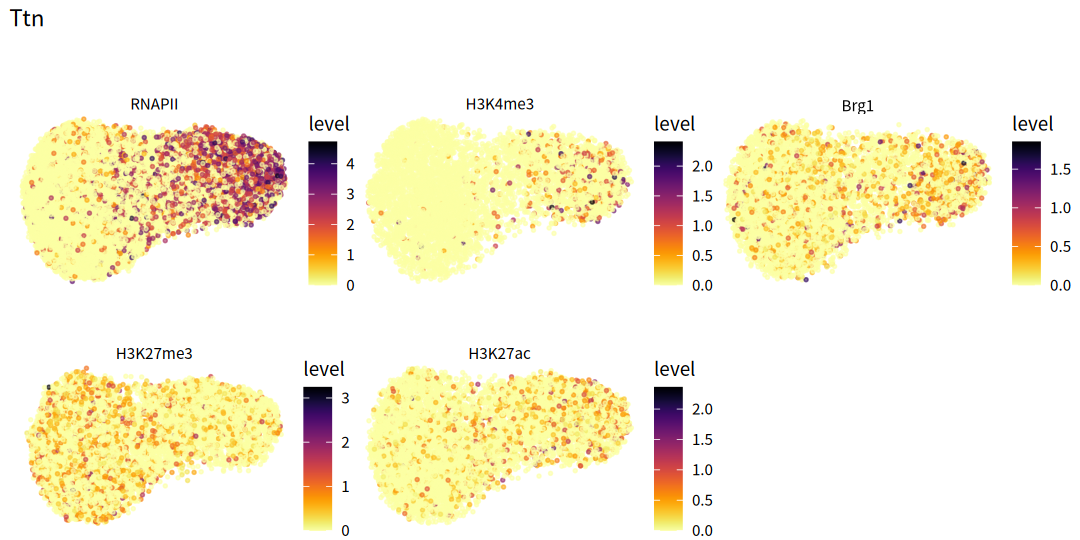

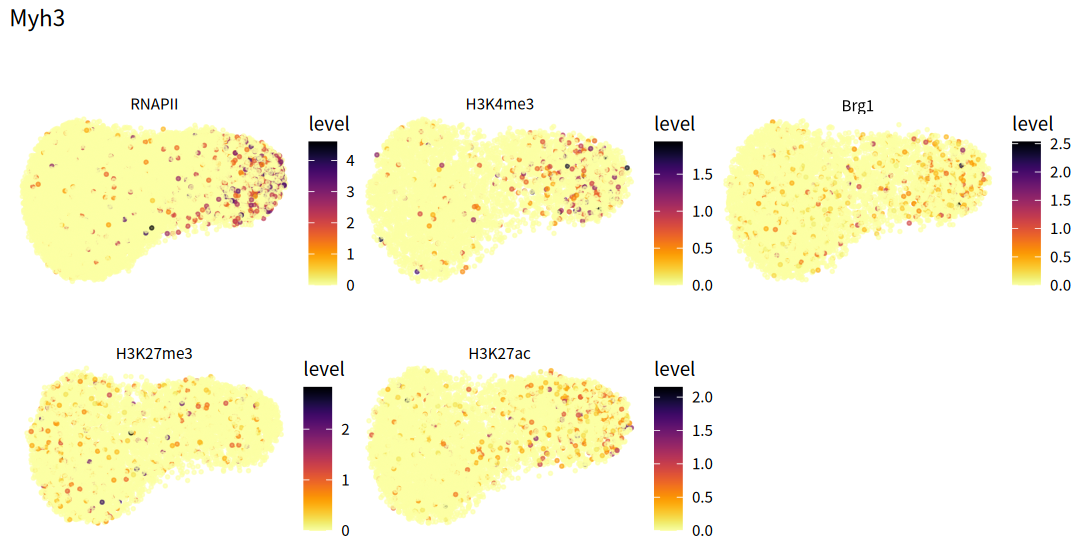

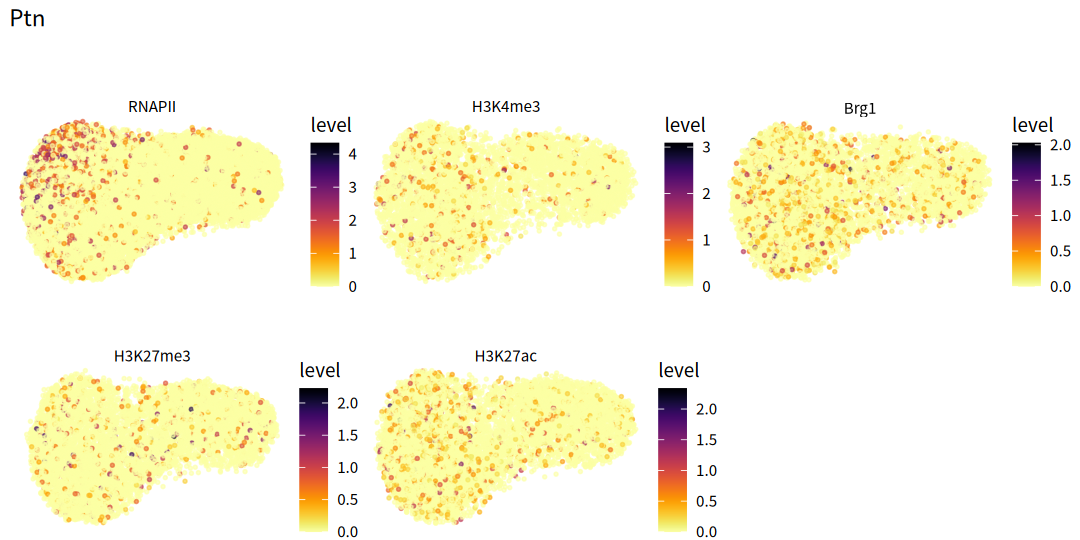

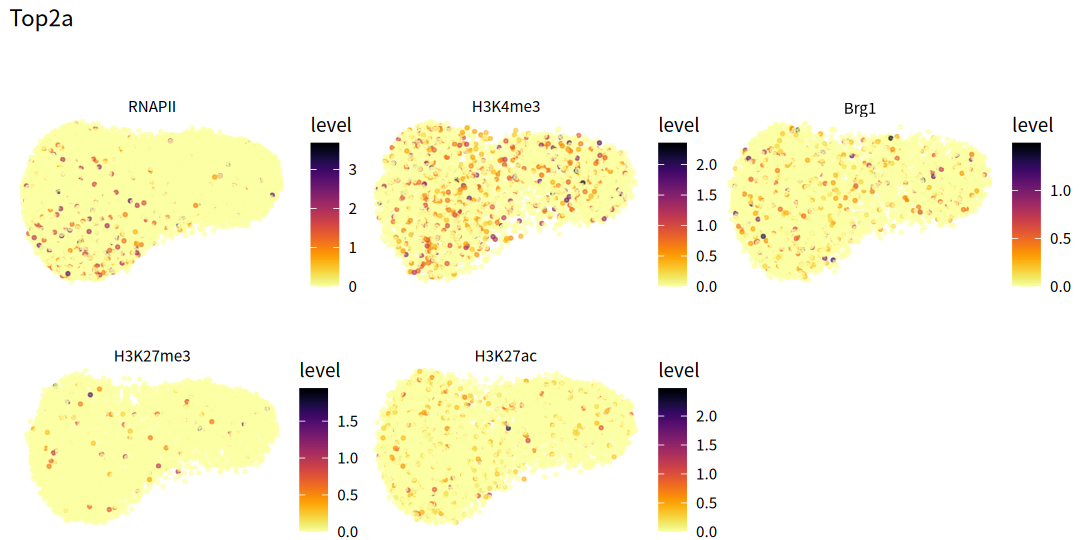

In [19]:
f <- function(SO,gene,assays){
  DefaultAssay(SO) <- "RNA"
  meta <- seu2tab(SO)
  metas <- list()
  for(i in assays){
    meta_ <- meta
    if(i != 'RNA') meta_ <- meta_ %>% filter(Pair == i)
    tmp <- FetchData(SO[[i]],gene,layer = 'data')[meta_$cell,]
    if(i == 'RNA') i <- 'RNAPII'
    metas[[i]] <- meta_ %>% mutate(level = tmp,Tar = i) 
  }
  metas %>% 
    map(~{
      lb <- .x$level
      lb <- min(lb[lb != 0])
      style(.x,'level',empha = lb,Theme = theme_void,alpha = .6,palette = F,size = .5)
      }) %>%
    patchwork::wrap_plots(nrow = 2) & patchwork::plot_annotation(title = gene) & 
    facet_wrap(~Tar) & 
    viridis::scale_color_viridis(option = "inferno", discrete = FALSE, direction = -1)
}

tar <- c('RNA',names(gsms))
genes <- c('Mef2a','Ttn','Myh3','Ptn','Top2a')
gs <- map(genes,~f(nih3t3_j,.x,tar))

options(repr.plot.width = 9, repr.plot.height = 4.5) 
print(gs[[1]])
print(gs[[2]])
print(gs[[3]])
print(gs[[4]])
print(gs[[5]])

In [20]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /usr/local/packages/mambaforge/lib/libmkl_gf_lp64.so.2;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=ja_JP.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=ja_JP.UTF-8        LC_COLLATE=ja_JP.UTF-8    
 [5] LC_MONETARY=ja_JP.UTF-8    LC_MESSAGES=ja_JP.UTF-8   
 [7] LC_PAPER=ja_JP.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=ja_JP.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Tokyo
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] lubridate_1.9.3        forcats_1.0.0          stringr_1.5.1         
 [4] dplyr_1.1.4            purrr_1.0.4            readr_2.1.5           
 [7] tidyr_1.3.1            tibble_3.2.1           ggplot2_3.5.2         
[10] tidyver